In [ ]:
!pip install Arabic-Stopwords

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.metrics import classification_report ,confusion_matrix ,accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import TreebankWordTokenizer
from keras.preprocessing.text import Tokenizer
import arabicstopwords.arabicstopwords as stp
from keras.models import Sequential
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from keras import layers
import seaborn as sns
import pandas as pd
import collections
import numpy as np
import matplotlib
import argparse
import codecs
import string
import pickle
import nltk
import math 
import sys
import re
import os
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = '/content/drive/MyDrive/Colab Notebooks/Tasks/questions classification by topic'
data_path = '/content/drive/MyDrive/Colab Notebooks/Tasks/questions classification by topic/DataSets'
results_path = '/content/drive/MyDrive/Colab Notebooks/Tasks/questions classification by topic/results'
results_path_deep = '/content/drive/MyDrive/Colab Notebooks/Tasks/questions classification by topic/result_with_deep_learning'

# Dataset Preparation (pre-processing)

In [ ]:
data = pd.read_csv(os.path.join(data_path,'after_collection_IslamWebAR&FullArabicData_v2.csv'))

In [ ]:
print(data.shape)
data.head()

(43771, 2)


,Question,Main Topic
0,هل هذا حديث يجوز الاستشهاد به قال رسول الله صل...,الحديث الشريف
1,ما صحة قراءة خمس آيات صباحا ومساء فيها خمسون ق...,الأذكار والأدعية
2,مات أبي ولم يكن له أبناء غيري (أنا أنثى بالغة)...,الفقه وفروعه
3,أنا طالبة في الثانوية العامة، أنعم عليّ الله س...,التربية و الآداب
4,بسم الله الرحمن الرحيمالسؤال/ من ماذا خلق الله...,الأطعمة والأشربة والصيد


In [ ]:
data['Main Topic'].value_counts()

الفقه وفروعه                20179
التربية و الآداب            11331
القرآن و علومه               2818
العقيدة الإسلامية            2751
العلم و الدعوة               2413
الحديث الشريف                1670
التراجم والأخبار              748
التاريخ و السيرة النبوية      534
الأذكار والأدعية              496
مشكلات اجتماعية وفكرية        447
الأطعمة والأشربة والصيد       342
السياسة الشرعية                42
Name: Main Topic, dtype: int64

In [ ]:
print(len(data['Main Topic'].tolist()))
list_of_label = list(set(data['Main Topic'].tolist()))
len(list_of_label)

43771


12

In [ ]:
def isNaN(string):
    if string == string:
        return string
    return "nan"

In [ ]:
data['Question'] = data['Question'].apply(isNaN)
data[data['Question']=='nan'].shape

(0, 2)

In [ ]:
print(len(data['Main Topic'].tolist()))
list_of_label = list(set(data['Main Topic'].tolist()))
len(list_of_label) 

43771


12

In [ ]:
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

In [ ]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

In [ ]:
def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text

In [ ]:
def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [ ]:
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [ ]:
def clean_text(text):
    text = remove_diacritics(text)
    text = remove_punctuations(text)
    text = remove_repeating_char(text)
    text = re.sub(r"([@A-Za-z0-9_ـــــــــــــ]+)|[^\w\s]|#|http\S+", " ", text)
    text = " ".join([word for word in text.split() if not stp.is_stop(u"{}".format(word))])
    text = " ".join([word for word in text.split() if len(word)>2])
    return text

In [ ]:
data['Question'] = data['Question'].apply(clean_text)

In [ ]:
data.head(3)

,Question,Main Topic
0,حديث يجوز الاستشهاد قال رسول اله صلى اله وسلم ...,الحديث الشريف
1,صحة قراءة خمس آيات صباحا خمسون قافا لتحصين وال...,الأذكار والأدعية
2,مات يكن أبناء أنثى بالغةورثته وعمي الأول شقيق ...,الفقه وفروعه


In [ ]:
def marg(text):
    return " ".join([sen for sen in text]) if type(text) is list else text

In [ ]:
def one_vs_all(data,list_of_label):
  X_train = []
  y_train = []
  X_test = []
  y_test = []
  labels = []
  for label in list_of_label:
      # if len(data[data['Main Topic']==label]['Question'].tolist())<1500:
      #   continue
      x = []
      y = []
      labels.append(label)
      xT1 = data[data['Main Topic']==label]['Question'].tolist()
      yT1_ = data[data['Main Topic']==label]['Main Topic'].tolist()
      yT1 = [1 for _ in range(len(yT1_))]
      for l in list_of_label:
          if l == label:
              continue
          LENGTH = len(data[data['Main Topic']==l]['Question'].tolist())
          p = math.ceil((((len(xT1)*100)/data.shape[0])/100)*LENGTH) 
          xT2 = data[data['Main Topic']==l]['Question'].tolist()[:p]
          yT2_ = data[data['Main Topic']==l]['Main Topic'].tolist()[:p]
          x.append(xT2)
          y.append([0 for _ in range(len(yT2_))])
      xT2 = list(np.concatenate(x).flat)
      yT2 = list(np.concatenate(y).flat)
      TX_train , TX_test , Ty_train , Ty_test = train_test_split(list(np.concatenate([xT1,xT2]).flat),np.array(list(np.concatenate([yT1,yT2]).flat)),test_size=0.10,random_state=1000)
      X_train.append(TX_train)
      y_train.append(Ty_train)
      X_test.append(TX_test)
      y_test.append(Ty_test)
  return X_train,y_train,X_test,y_test,labels

In [ ]:
X_train,y_train,X_test,y_test,labels = one_vs_all(data,list_of_label)
len(X_train)

12

In [ ]:
for i,y in enumerate(y_train):
    print("=================","for data :",labels[i],"==================")
    print(len(y))
    elements_count = collections.Counter(y)
    for key, value in elements_count.items():
        print(f"{key}: {value}")

================= for data : التراجم والأخبار ==================
1340
0: 669
1: 671
================= for data : العلم و الدعوة ==================
4229
1: 2163
0: 2066
================= for data : التاريخ و السيرة النبوية ==================
962
0: 472
1: 490
================= for data : القرآن و علومه ==================
4914
1: 2546
0: 2368
================= for data : الحديث الشريف ==================
2953
1: 1503
0: 1450
================= for data : الفقه وفروعه ==================
27954
1: 18152
0: 9802
================= for data : التربية و الآداب ==================
17760
1: 10209
0: 7551
================= for data : السياسة الشرعية ==================
80
1: 39
0: 41
================= for data : الأذكار والأدعية ==================
892
0: 443
1: 449
================= for data : مشكلات اجتماعية وفكرية ==================
806
1: 404
0: 402
================= for data : العقيدة الإسلامية ==================
4802
1: 2469
0: 2333
================= for data : الأطعمة والأشربة والصيد ===========

In [ ]:
for i,y in enumerate(y_test):
    print("=================","for data :",labels[i],"==================")
    print(len(y))
    elements_count = collections.Counter(y)
    for key, value in elements_count.items():
        print(f"{key}: {value}")

================= for data : التراجم والأخبار ==================
149
1: 77
0: 72
================= for data : العلم و الدعوة ==================
470
1: 250
0: 220
================= for data : التاريخ و السيرة النبوية ==================
107
0: 63
1: 44
================= for data : القرآن و علومه ==================
547
1: 272
0: 275
================= for data : الحديث الشريف ==================
329
1: 167
0: 162
================= for data : الفقه وفروعه ==================
3107
1: 2027
0: 1080
================= for data : التربية و الآداب ==================
1974
1: 1122
0: 852
================= for data : السياسة الشرعية ==================
9
0: 6
1: 3
================= for data : الأذكار والأدعية ==================
100
0: 53
1: 47
================= for data : مشكلات اجتماعية وفكرية ==================
90
0: 47
1: 43
================= for data : العقيدة الإسلامية ==================
534
0: 252
1: 282
================= for data : الأطعمة والأشربة والصيد ==================
69
0: 30
1: 39


In [ ]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [ ]:
def print_result(y_pred, y_test , title ,color):
    y_test = list(map(_replaceitem, y_test))
    y_pred = list(map(_replaceitem, y_pred))
    if len(y_test) < len(y_pred):
        y_pred = y_pred[: len(y_test)]
    elif len(y_test) > len(y_pred):
        y_test = y_test[: len(y_pred)]
    accuracy = accuracy_score(y_pred, y_test)
    classification_rep = classification_report(y_test, y_pred)
    con_matrix = confusion_matrix(y_test, y_pred)
    if len(con_matrix)==1:
        if len(con_matrix[0])==1:
            con_matrix = list(con_matrix)
            con_matrix[0] = list(con_matrix[0])
            con_matrix[0].append(0)
            con_matrix = np.array([con_matrix[0],[0,0]])
    plt.figure(figsize=(25,15))
    plt.subplot(2,1,1)
    group_names =['Not one']

    if y_test is np.ndarray:
      T1 = np.count_nonzero(y_test == 0) if np.count_nonzero(y_test == 0) !=0 else 1
      T2 = np.count_nonzero(y_test == 1)  if np.count_nonzero(y_test == 1) !=0 else 1
    else:
      T1 = y_test.count(0) if y_test.count(0)!=0 else 1
      T2 = y_test.count(1) if y_test.count(1)!=0 else 1
    group_counts = con_matrix
    group_percentages = np.round(con_matrix / np.array([[T1 , T1],[T2 , T2]]),3)
    t = 0.5
    plt.text(x=0.0 , y = 2.6, s =  "confusion_matrix :",fontsize=15)
    plt.text(x=0.0 , y = 3.3-t, s =  'Not one ',fontsize=15)
    plt.text(x=0.0 , y = 3.4-t, s =  'One ',fontsize=15)
    plt.text(x=0.3 , y = 3.2-t, s =  'Not one ',fontsize=15)
    plt.text(x=0.6 , y = 3.2-t, s =  'One',fontsize=15)
    plt.text(x=0.3 , y = 3.3-t, s =  "{}".format(con_matrix[0][0]),fontsize=15)
    plt.text(x=0.6 , y = 3.3-t, s =  "{}".format(con_matrix[0][1]),fontsize=15)
    plt.text(x=0.3 , y = 3.4-t, s =  "{}".format(con_matrix[1][0]),fontsize=15)
    plt.text(x=0.6 , y = 3.4-t, s =  "{}".format(con_matrix[1][1]),fontsize=15)
    sns.heatmap(group_percentages,xticklabels= ['Not one' , 'One'], yticklabels=['Not one' , 'One']  , annot=True, annot_kws={"size": 16},fmt='g', cmap=color)
    plt.title(title ,  fontsize = 18)
    plt.text(x =0,y = 2.3 , s = "accuracy  score on test : {}".format(accuracy),fontsize=15)    
    plt.text(x=0 , y = 3.9, s =  "classification_report :\n {}".format(classification_rep),fontsize=15)
    plt.xlabel("Predicted value")
    plt.ylabel("Real value")
    plt.savefig("{} .png".format(os.path.join(os.path.join(results_path_deep,"Image"),title)))
    plt.show()

In [ ]:
def tfidf_vectorizer(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

In [ ]:
def count_vectorizer(data): # Bag of words (BOW)  , binary=True
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
def CreatNetwork(vocab_size):
  model = Sequential()
  model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
  # model.add(Embedding(vocab_size, embedding_dim, input_length=max_length,trainable = False))
  model.add(layers.Conv1D(128, 3, activation='relu'))
  model.add(layers.MaxPooling1D(3))
  model.add(layers.Conv1D(128, 3, activation='relu'))
  model.add(layers.MaxPooling1D(3))
  model.add(layers.Conv1D(128, 3, activation='relu'))
  model.add(layers.MaxPooling1D(3))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # model.summary()
  return model

In [ ]:
def creat_Network(vocab_size):
  model=Sequential()
  model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
  model.add(layers.LSTM(units=50, input_shape=(None, 50),activation='relu'))#, return_sequences=True))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(32,activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

In [ ]:
def Creat_Network(vocab_size):
  model = Sequential()
  model.add(layers.Embedding(vocab_size, embedding_dim,input_length=maxlen))
  model.add(layers.Conv1D(128, 3, activation='relu'))
  model.add(layers.GlobalMaxPool1D())
  model.add(layers.Flatten())
  model.add(layers.Dense(10, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  # model.summary()
  return model

In [ ]:
def train_models(X_train, y_train,vocab_size,labels):
    model = creat_Network(vocab_size)
    history = model.fit(X_train, y_train, validation_split=0.10,epochs=10,callbacks=[es],batch_size=64,verbose=1)
    return model , history

In [ ]:
def _replaceitem(x):
    if type(x) is list:
        if x[0]<0.5:
            return 0.0
    else:
        x = float(x)
        if x<0.5:
            return 0.0
    return 1.0

In [ ]:
def evaluate_result(model,X_test,y_test,label,history):
    print("==========",label,"==========")
    y_predict = model.predict(X_test)
    print_result(y_predict, y_test , label ,color='Blues')
    if not (history is None):
      plot_history(history)

In [ ]:
def Creat_Container_Result():
    Container_Result = {}
    Container_Result['Network'] = {}
    for label in labels:
      Container_Result['Network'][label] = []
    return Container_Result

In [ ]:
labels

['التراجم والأخبار',
 'العلم و الدعوة',
 'التاريخ و السيرة النبوية',
 'القرآن و علومه',
 'الحديث الشريف',
 'الفقه وفروعه',
 'التربية و الآداب',
 'السياسة الشرعية',
 'الأذكار والأدعية',
 'مشكلات اجتماعية وفكرية',
 'العقيدة الإسلامية',
 'الأطعمة والأشربة والصيد']

### with TFIDF vectorizer 

In [ ]:
# save_model = {}
# save_model['Network'] = {}
# for i in labels:
#     save_model['Network'][i] = []

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

embedding_dim = 200
num_words = 512
maxlen = 2048
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
def pad_sequences_vectorizer(X_train):
    tokenizer = Tokenizer(num_words)
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    # input_Dim = X_train[0].shape
    return X_train,vocab_size,tokenizer

*******************************************************************************************
****************************** result for data التراجم والأخبار ******************************
*******************************************************************************************
tokenizeation ....
training .....


Epoch 1/10
19/19 [==============================] - 102s 5s/step - loss: 0.6938 - accuracy: 0.4834 - val_loss: 0.6967 - val_accuracy: 0.4179
Epoch 2/10
19/19 [==============================] - 82s 4s/step - loss: 0.6930 - accuracy: 0.5083 - val_loss: 0.6968 - val_accuracy: 0.4179
Epoch 3/10
19/19 [==============================] - 75s 4s/step - loss: 0.6933 - accuracy: 0.5066 - val_loss: 0.6977 - val_accuracy: 0.4179
Epoch 3: early stopping
evaluation ....
========== التراجم والأخبار ==========
5/5 [==============================] - 1s 231ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


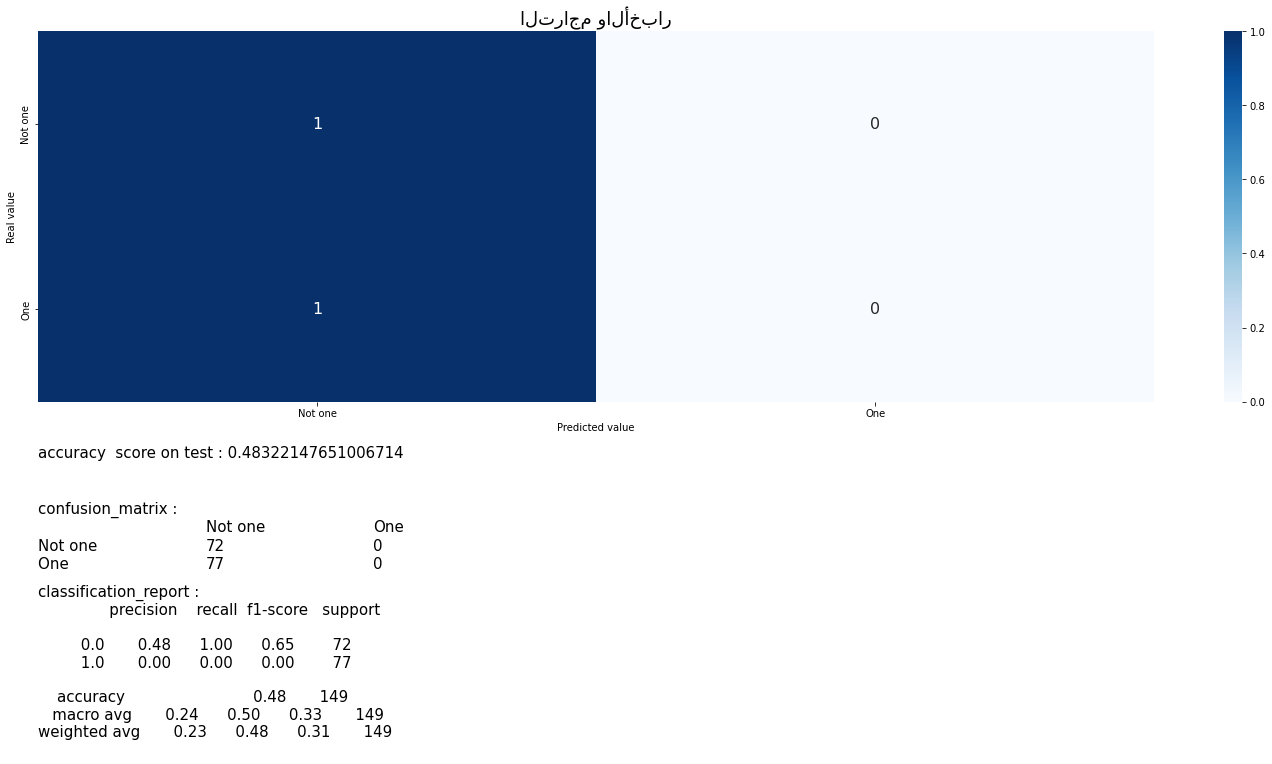

*******************************************************************************************
****************************** result for data العلم و الدعوة ******************************
*******************************************************************************************
tokenizeation ....


training .....
Epoch 1/10
60/60 [==============================] - 240s 4s/step - loss: 0.6934 - accuracy: 0.4976 - val_loss: 0.6924 - val_accuracy: 0.5296
Epoch 2/10
60/60 [==============================] - 238s 4s/step - loss: 0.6934 - accuracy: 0.5050 - val_loss: 0.6921 - val_accuracy: 0.5296
Epoch 3/10
60/60 [==============================] - 234s 4s/step - loss: 0.6933 - accuracy: 0.5063 - val_loss: 0.6920 - val_accuracy: 0.5296
Epoch 4/10
60/60 [==============================] - 235s 4s/step - loss: 0.6932 - accuracy: 0.5089 - val_loss: 0.6925 - val_accuracy: 0.5296
Epoch 5/10
60/60 [==============================] - 235s 4s/step - loss: 0.6930 - accuracy: 0.5095 - val_loss: 0.6923 - val_accuracy: 0.5296
Epoch 5: early stopping
evaluation ....
========== العلم و الدعوة ==========
15/15 [==============================] - 4s 231ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


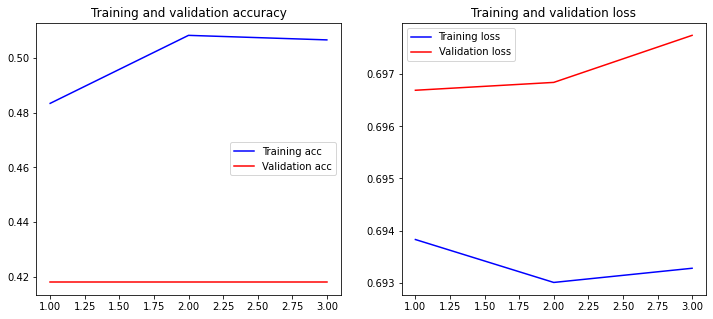

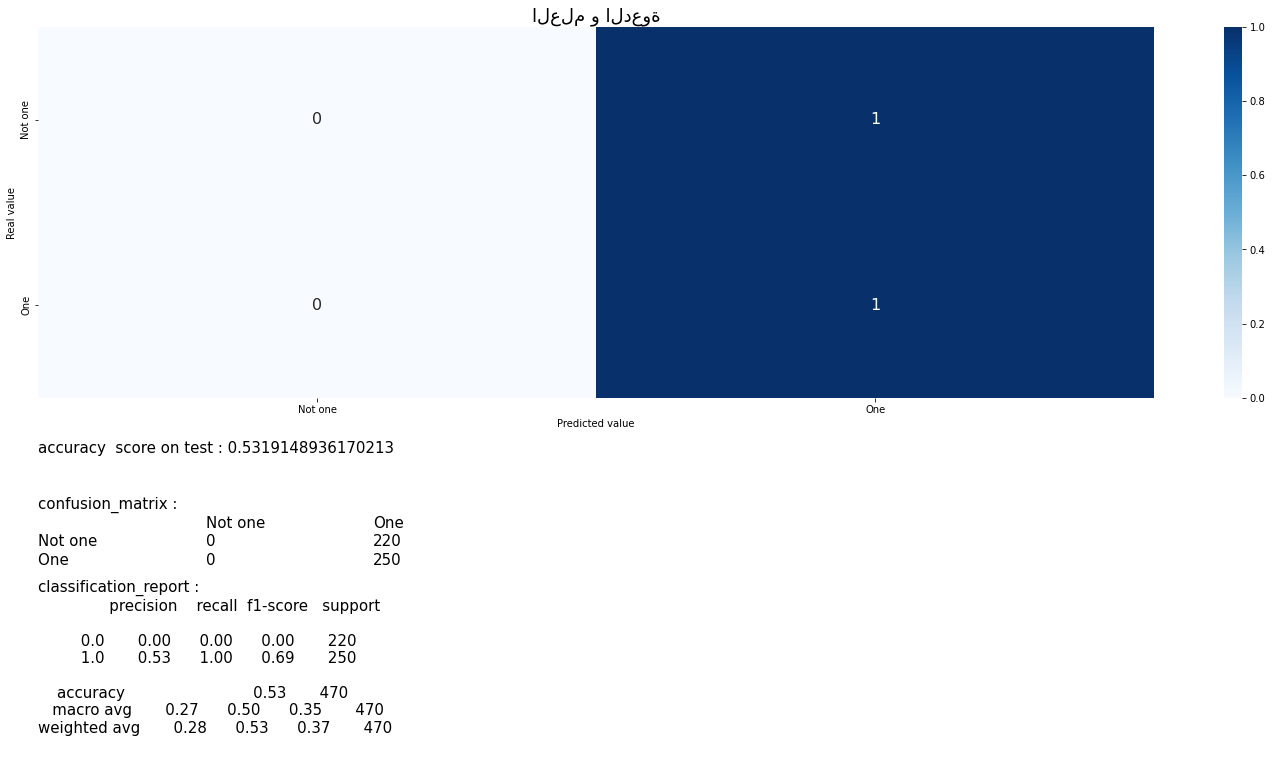

*******************************************************************************************
****************************** result for data التاريخ و السيرة النبوية ******************************
*******************************************************************************************
tokenizeation ....
training .....
Epoch 1/10
14/14 [==============================] - 55s 4s/step - loss: 0.6935 - accuracy: 0.5052 - val_loss: 0.6917 - val_accuracy: 0.5670
Epoch 2/10
14/14 [==============================] - 53s 4s/step - loss: 0.6930 - accuracy: 0.5202 - val_loss: 0.6918 - val_accuracy: 0.5670
Epoch 3/10
14/14 [==============================] - 54s 4s/step - loss: 0.6936 - accuracy: 0.4867 - val_loss: 0.6922 - val_accuracy: 0.5670
Epoch 3: early stopping
evaluation ....
========== التاريخ و السيرة النبوية ==========
4/4 [==============================] - 1s 241ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


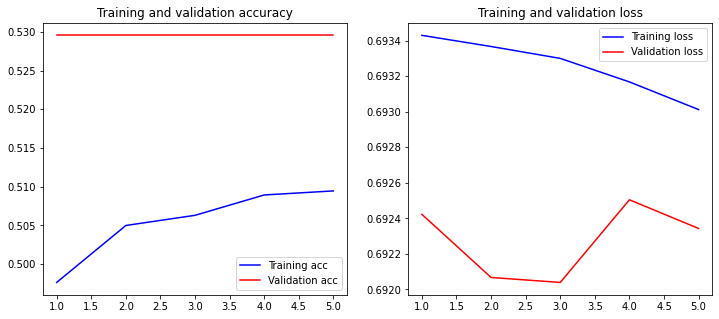

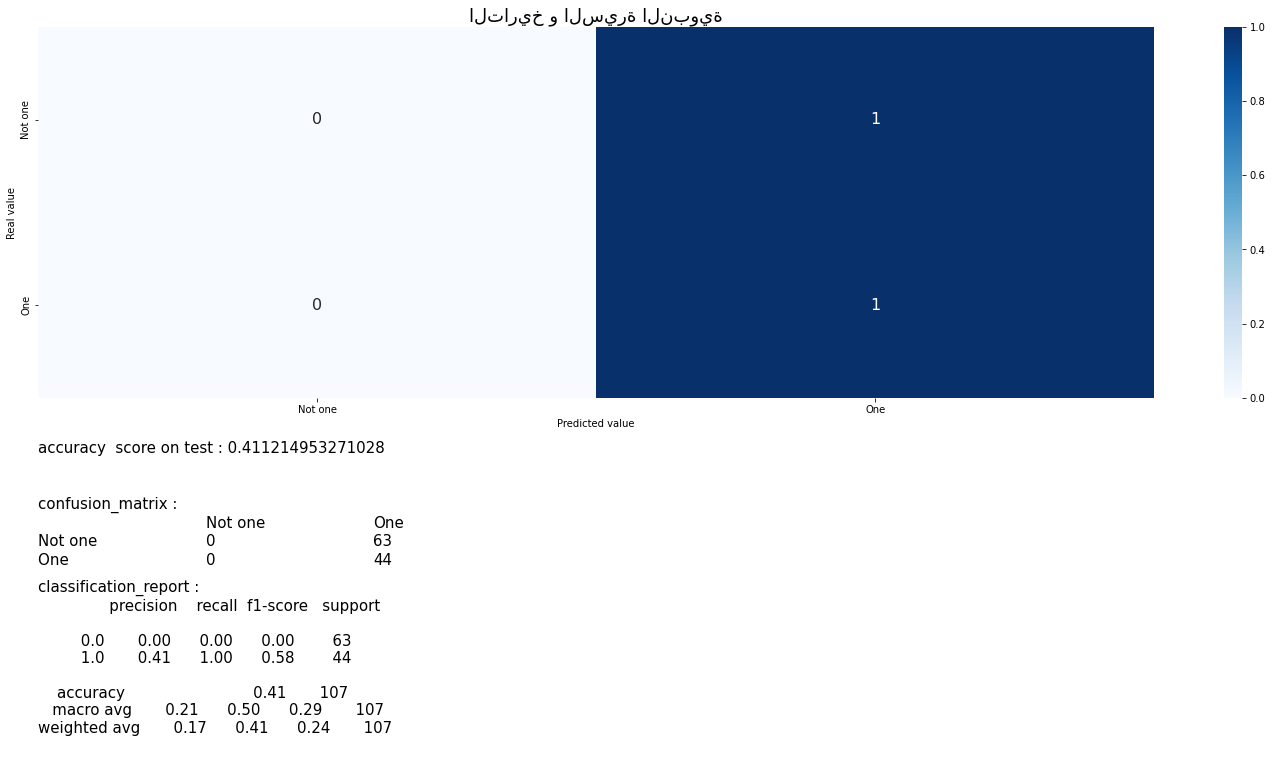

*******************************************************************************************
****************************** result for data القرآن و علومه ******************************
*******************************************************************************************
tokenizeation ....


training .....
Epoch 1/10
70/70 [==============================] - 265s 4s/step - loss: 0.6931 - accuracy: 0.5100 - val_loss: 0.6922 - val_accuracy: 0.5305
Epoch 2/10
70/70 [==============================] - 268s 4s/step - loss: 0.6930 - accuracy: 0.5142 - val_loss: 0.6915 - val_accuracy: 0.5305
Epoch 3/10
70/70 [==============================] - 266s 4s/step - loss: 0.6928 - accuracy: 0.5183 - val_loss: 0.6917 - val_accuracy: 0.5305
Epoch 4/10
70/70 [==============================] - 265s 4s/step - loss: 0.6929 - accuracy: 0.5165 - val_loss: 0.6917 - val_accuracy: 0.5305
Epoch 4: early stopping
evaluation ....
========== القرآن و علومه ==========
18/18 [==============================] - 4s 235ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


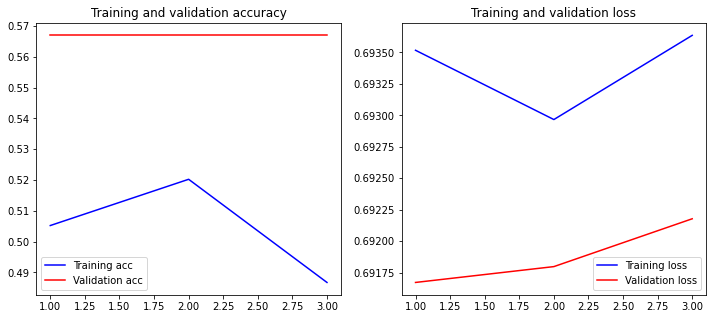

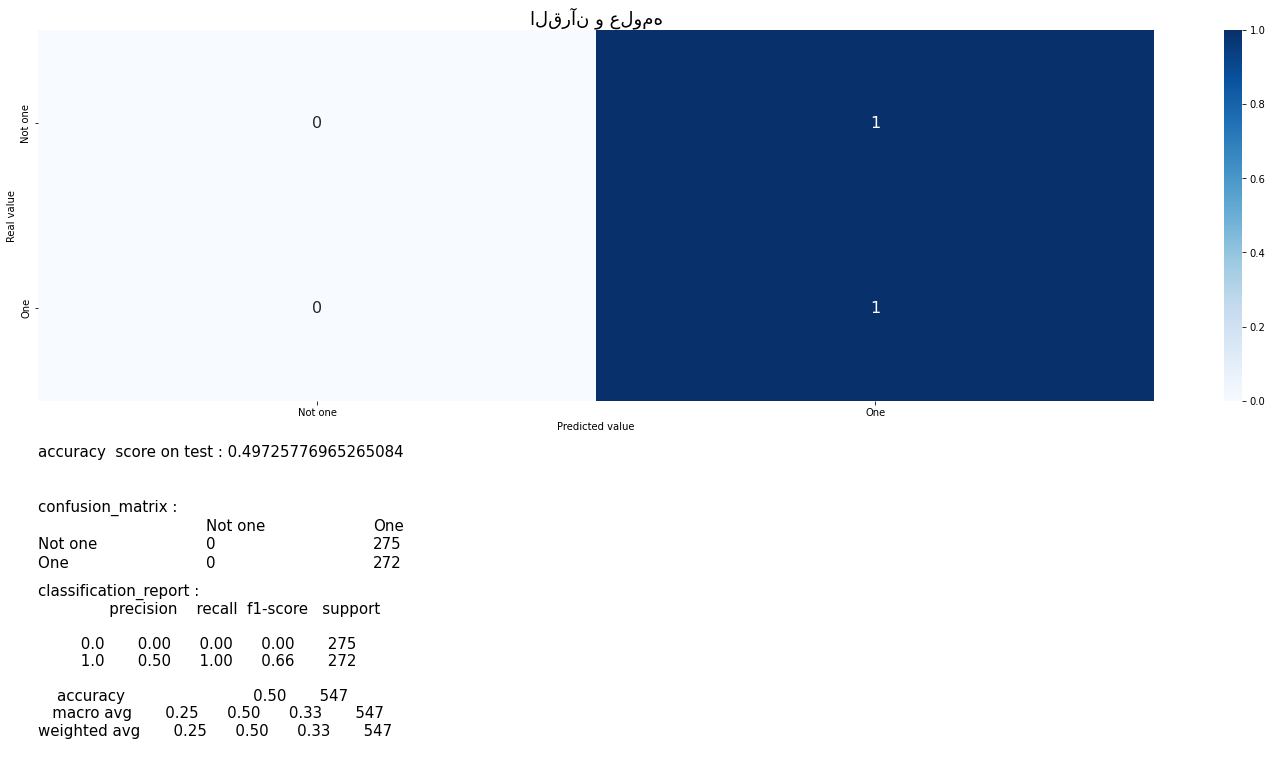

*******************************************************************************************
****************************** result for data الحديث الشريف ******************************
*******************************************************************************************
tokenizeation ....


training .....
Epoch 1/10
42/42 [==============================] - 160s 4s/step - loss: 0.6935 - accuracy: 0.5062 - val_loss: 0.6930 - val_accuracy: 0.5101
Epoch 2/10
42/42 [==============================] - 157s 4s/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6929 - val_accuracy: 0.5101
Epoch 3/10
42/42 [==============================] - 159s 4s/step - loss: 0.6929 - accuracy: 0.5077 - val_loss: 0.6930 - val_accuracy: 0.5101
Epoch 4/10
42/42 [==============================] - 160s 4s/step - loss: 0.6929 - accuracy: 0.5070 - val_loss: 0.6930 - val_accuracy: 0.5101
Epoch 4: early stopping
evaluation ....
========== الحديث الشريف ==========
11/11 [==============================] - 3s 232ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


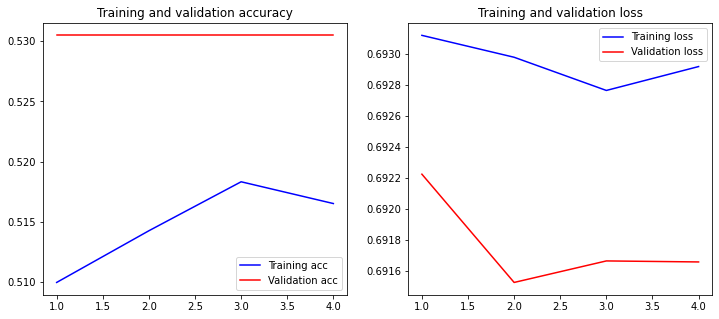

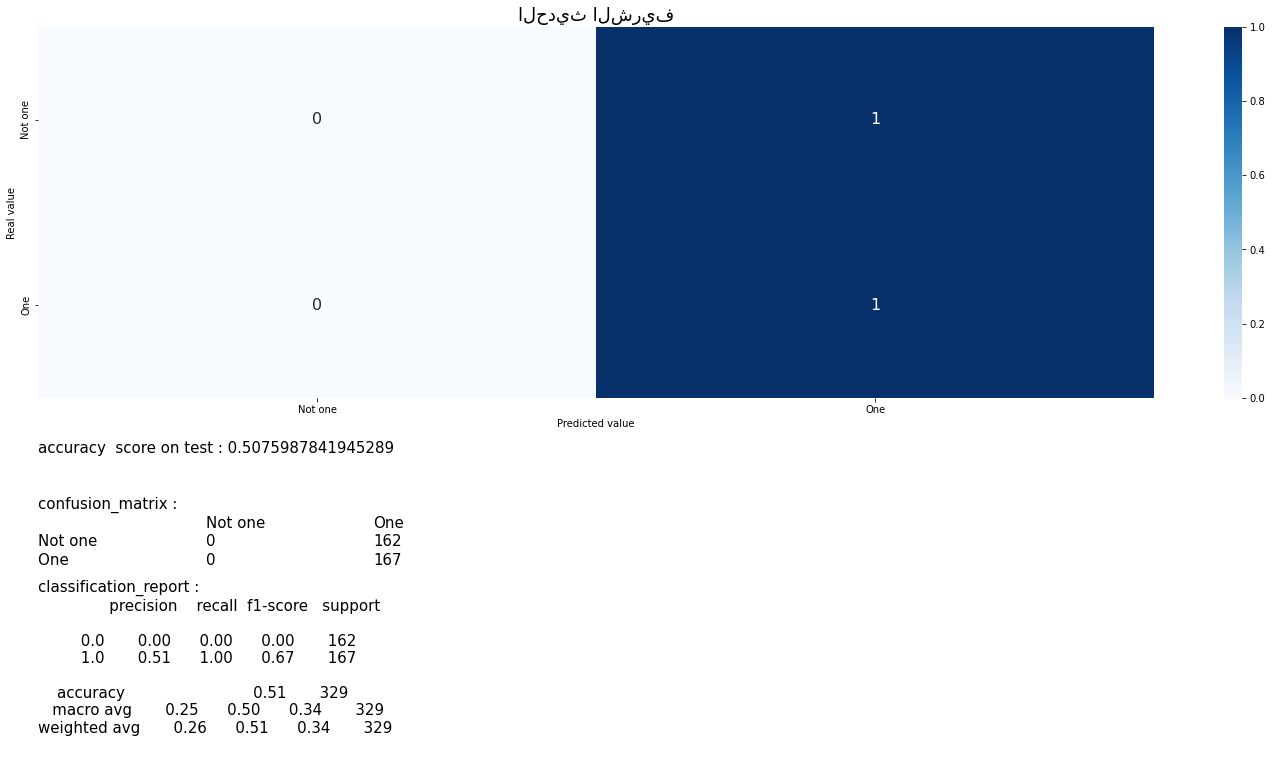

*******************************************************************************************
****************************** result for data الفقه وفروعه ******************************
*******************************************************************************************
tokenizeation ....


training .....
Epoch 1/10
394/394 [==============================] - 1486s 4s/step - loss: 0.6506 - accuracy: 0.6487 - val_loss: 0.6445 - val_accuracy: 0.6552
Epoch 2/10
394/394 [==============================] - 1459s 4s/step - loss: 0.6494 - accuracy: 0.6487 - val_loss: 0.6447 - val_accuracy: 0.6552
Epoch 3/10
394/394 [==============================] - 1440s 4s/step - loss: 0.6493 - accuracy: 0.6487 - val_loss: 0.6446 - val_accuracy: 0.6552
Epoch 3: early stopping
evaluation ....
========== الفقه وفروعه ==========
98/98 [==============================] - 24s 241ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


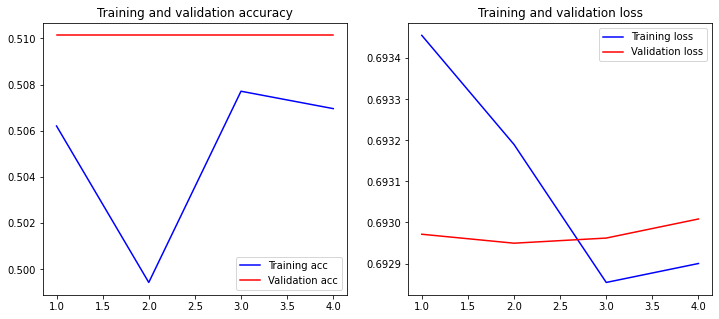

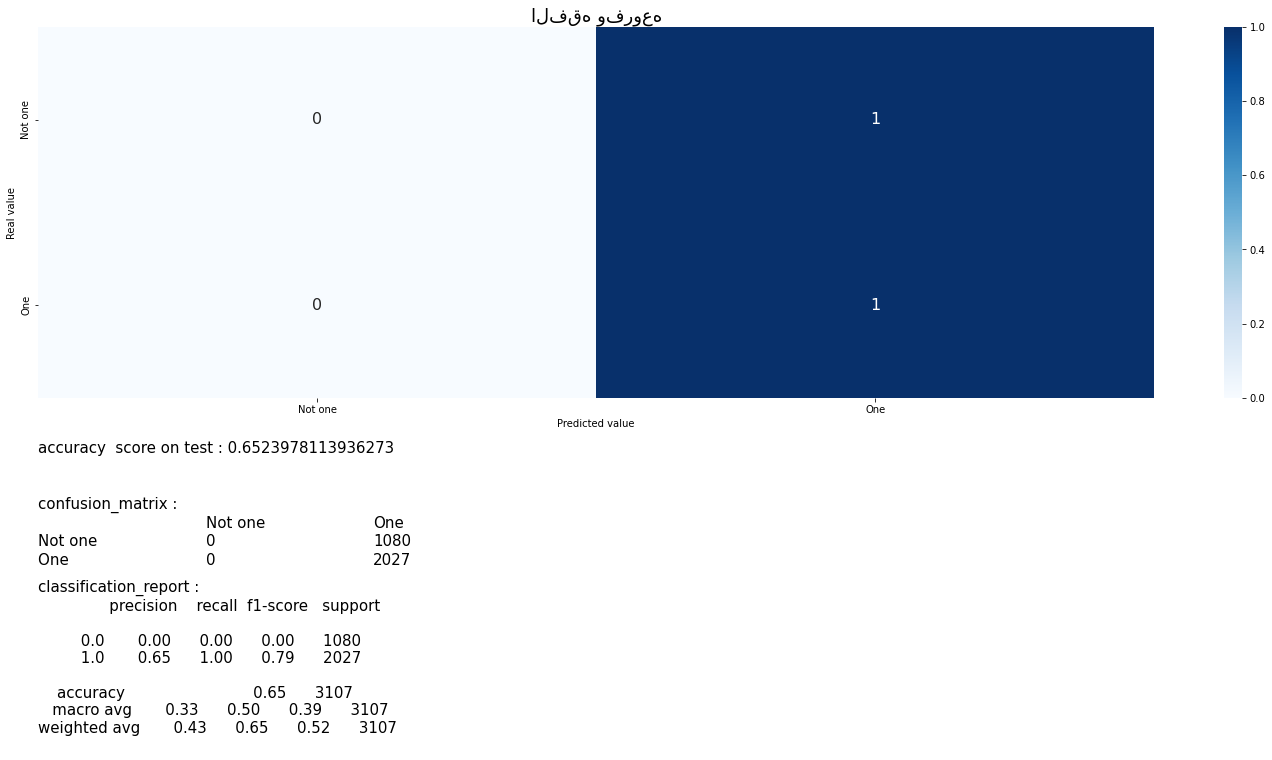

*******************************************************************************************
****************************** result for data التربية و الآداب ******************************
*******************************************************************************************
tokenizeation ....


training .....
Epoch 1/10
250/250 [==============================] - 924s 4s/step - loss: 0.6829 - accuracy: 0.5746 - val_loss: 0.6835 - val_accuracy: 0.5749
Epoch 2/10
250/250 [==============================] - 903s 4s/step - loss: 0.6823 - accuracy: 0.5748 - val_loss: 0.6823 - val_accuracy: 0.5749
Epoch 3/10
250/250 [==============================] - 897s 4s/step - loss: 0.6827 - accuracy: 0.5748 - val_loss: 0.6820 - val_accuracy: 0.5749
Epoch 4/10
250/250 [==============================] - 939s 4s/step - loss: 0.6825 - accuracy: 0.5748 - val_loss: 0.6819 - val_accuracy: 0.5749
Epoch 5/10
250/250 [==============================] - 928s 4s/step - loss: 0.6825 - accuracy: 0.5748 - val_loss: 0.6819 - val_accuracy: 0.5749
Epoch 6/10
250/250 [==============================] - 925s 4s/step - loss: 0.6823 - accuracy: 0.5748 - val_loss: 0.6822 - val_accuracy: 0.5749
Epoch 6: early stopping
evaluation ....
========== التربية و الآداب ==========
62/62 [==============================] - 15s 245

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


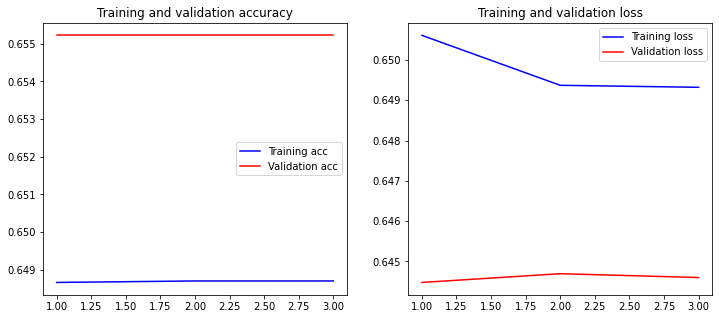

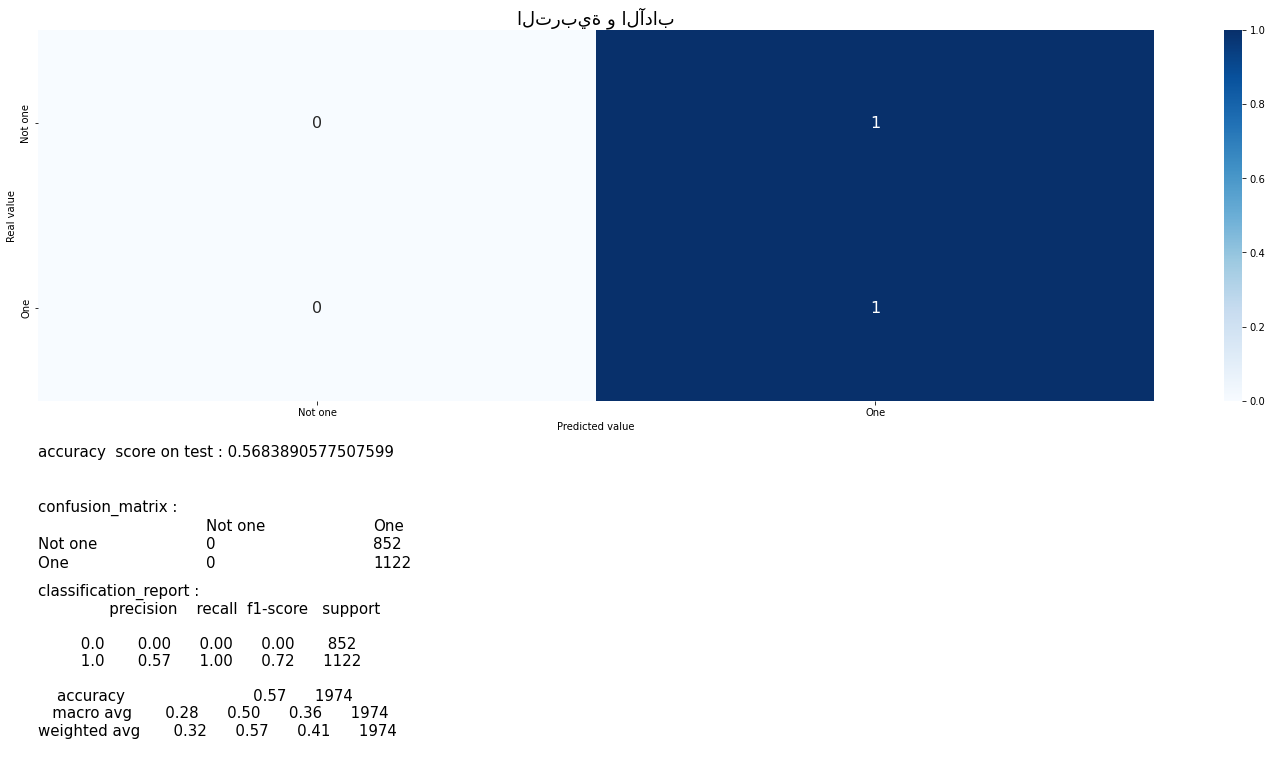

*******************************************************************************************
****************************** result for data السياسة الشرعية ******************************
*******************************************************************************************
tokenizeation ....
training .....
Epoch 1/10
2/2 [==============================] - 9s 4s/step - loss: 0.6922 - accuracy: 0.5417 - val_loss: 0.7008 - val_accuracy: 0.2500
Epoch 2/10
2/2 [==============================] - 7s 4s/step - loss: 0.6935 - accuracy: 0.5278 - val_loss: 0.6993 - val_accuracy: 0.2500
Epoch 3/10
2/2 [==============================] - 7s 4s/step - loss: 0.6918 - accuracy: 0.5556 - val_loss: 0.6937 - val_accuracy: 0.2500
Epoch 4/10
2/2 [==============================] - 7s 4s/step - loss: 0.6932 - accuracy: 0.5139 - val_loss: 0.6903 - val_accuracy: 0.7500
Epoch 5/10
2/2 [==============================] - 8s 4s/step - loss: 0.6928 - accuracy: 0.5694 - val_loss: 0.6875 - val_accuracy: 0.7500
Epo

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


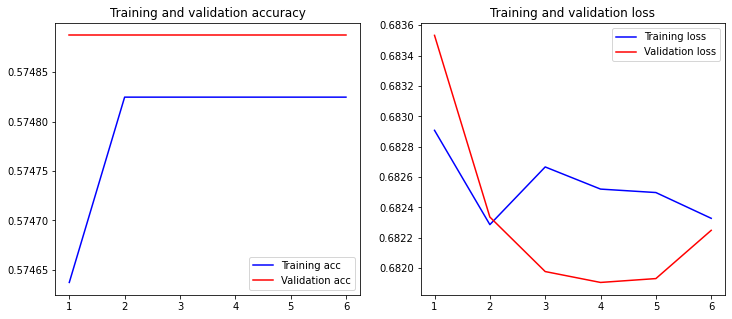

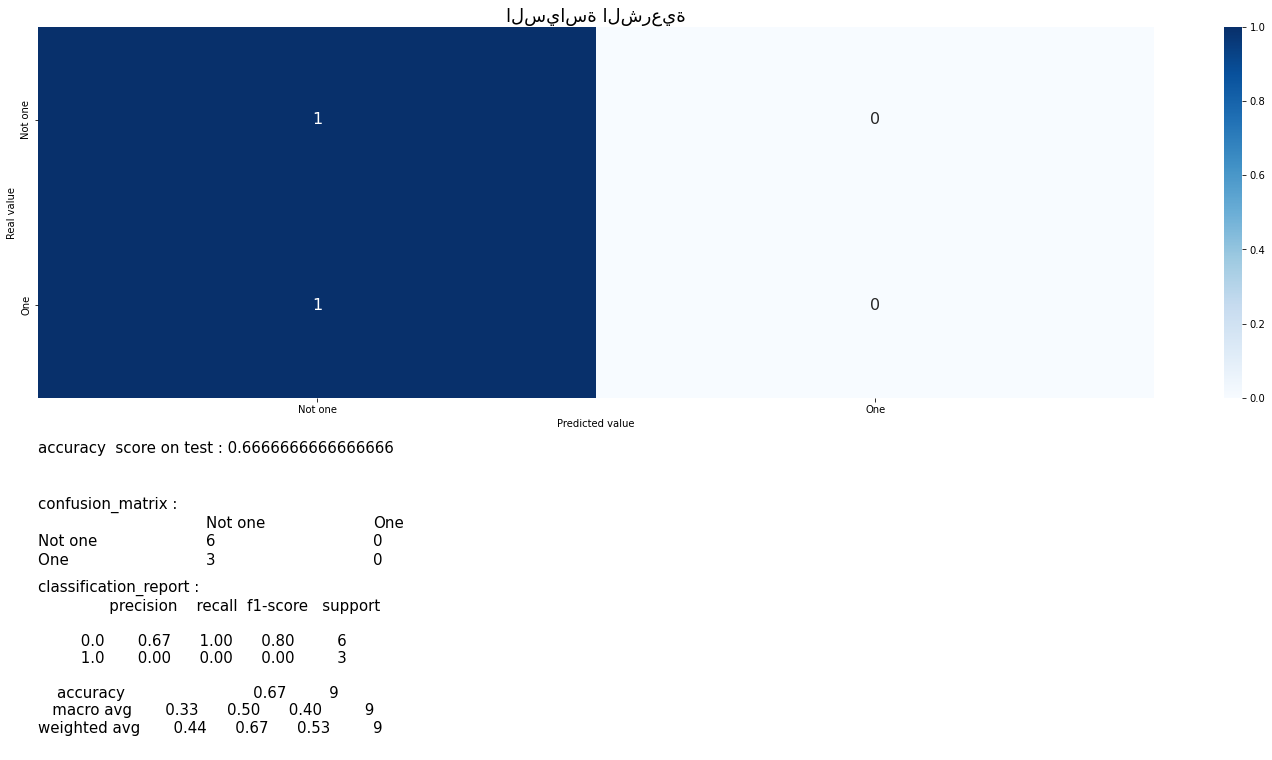

*******************************************************************************************
****************************** result for data الأذكار والأدعية ******************************
*******************************************************************************************
tokenizeation ....
training .....
Epoch 1/10
13/13 [==============================] - 50s 4s/step - loss: 0.6950 - accuracy: 0.4825 - val_loss: 0.6929 - val_accuracy: 0.5111
Epoch 2/10
13/13 [==============================] - 48s 4s/step - loss: 0.6932 - accuracy: 0.5112 - val_loss: 0.6932 - val_accuracy: 0.4889
Epoch 3/10
13/13 [==============================] - 50s 4s/step - loss: 0.6935 - accuracy: 0.5087 - val_loss: 0.6938 - val_accuracy: 0.4889
Epoch 3: early stopping
evaluation ....
========== الأذكار والأدعية ==========
4/4 [==============================] - 1s 239ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


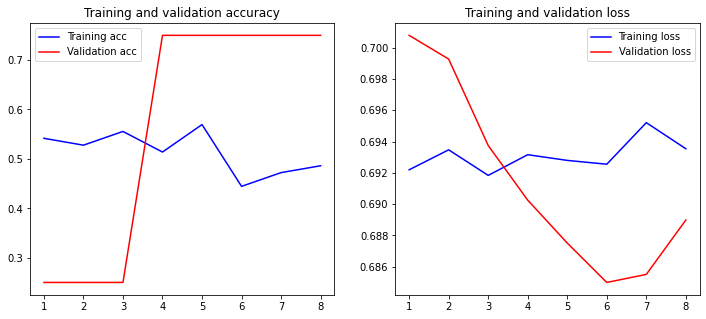

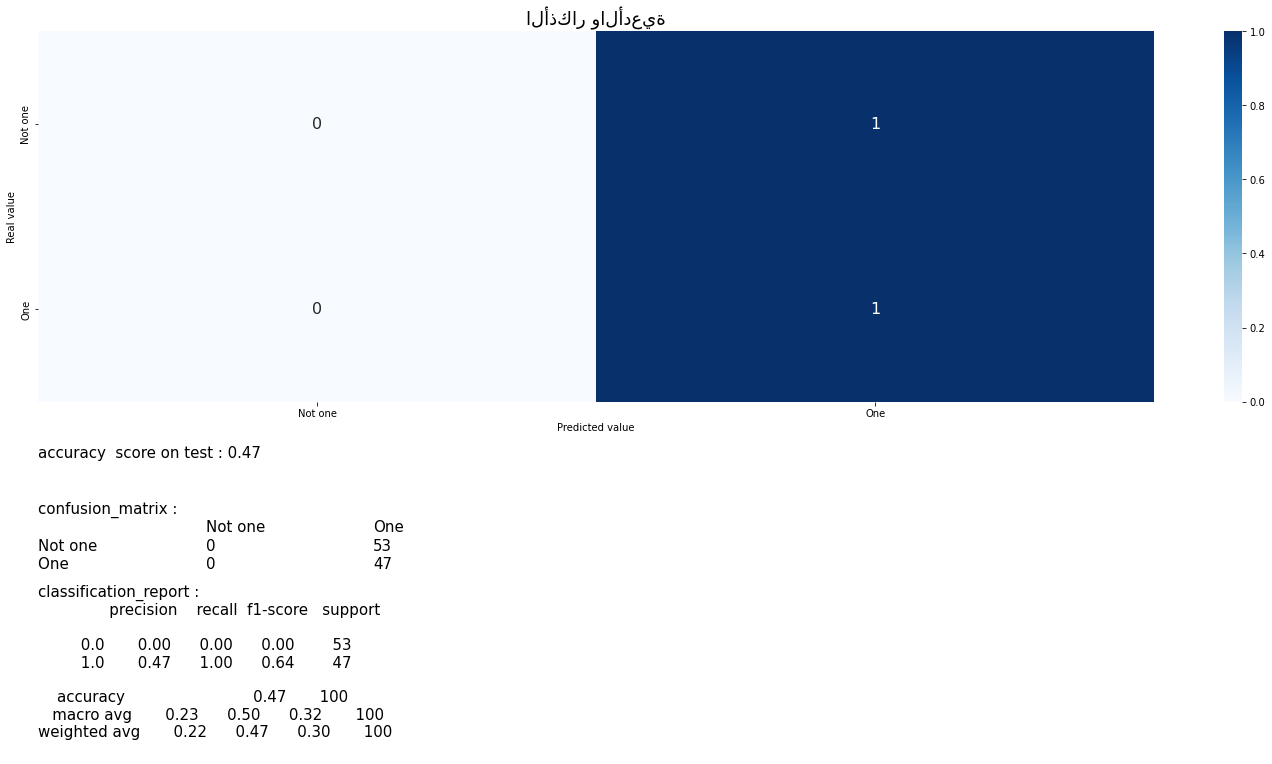

*******************************************************************************************
****************************** result for data مشكلات اجتماعية وفكرية ******************************
*******************************************************************************************
tokenizeation ....
training .....
Epoch 1/10
12/12 [==============================] - 46s 4s/step - loss: 0.6938 - accuracy: 0.4828 - val_loss: 0.6931 - val_accuracy: 0.5062
Epoch 2/10
12/12 [==============================] - 44s 4s/step - loss: 0.6933 - accuracy: 0.5103 - val_loss: 0.6932 - val_accuracy: 0.4938
Epoch 3/10
12/12 [==============================] - 43s 4s/step - loss: 0.6932 - accuracy: 0.4800 - val_loss: 0.6932 - val_accuracy: 0.4938
Epoch 3: early stopping
evaluation ....
========== مشكلات اجتماعية وفكرية ==========
3/3 [==============================] - 1s 234ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


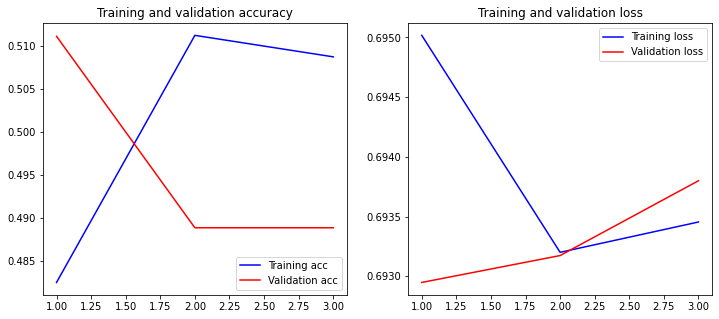

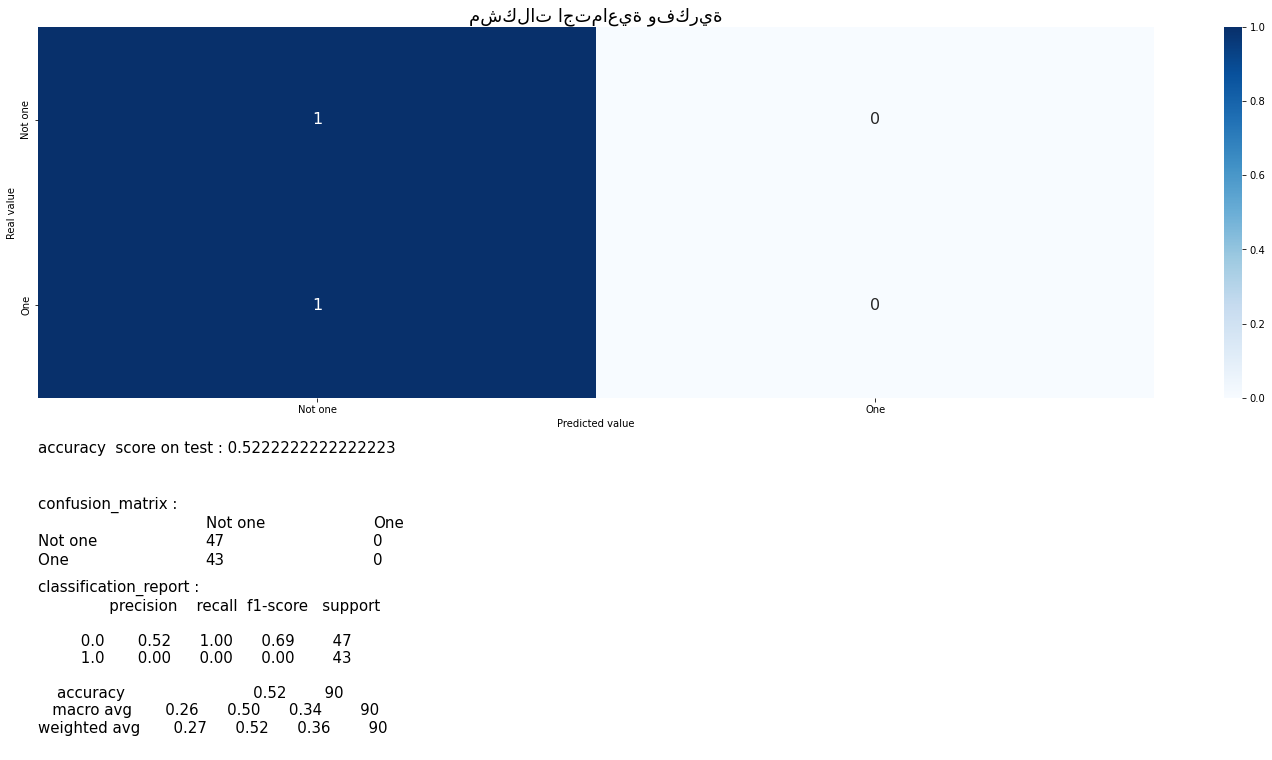

*******************************************************************************************
****************************** result for data العقيدة الإسلامية ******************************
*******************************************************************************************
tokenizeation ....


training .....
Epoch 1/10
68/68 [==============================] - 262s 4s/step - loss: 0.6931 - accuracy: 0.5112 - val_loss: 0.6924 - val_accuracy: 0.5198
Epoch 2/10
68/68 [==============================] - 256s 4s/step - loss: 0.6933 - accuracy: 0.5138 - val_loss: 0.6924 - val_accuracy: 0.5198
Epoch 3/10
68/68 [==============================] - 258s 4s/step - loss: 0.6930 - accuracy: 0.5145 - val_loss: 0.6925 - val_accuracy: 0.5198
Epoch 3: early stopping
evaluation ....
========== العقيدة الإسلامية ==========


17/17 [==============================] - 4s 233ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


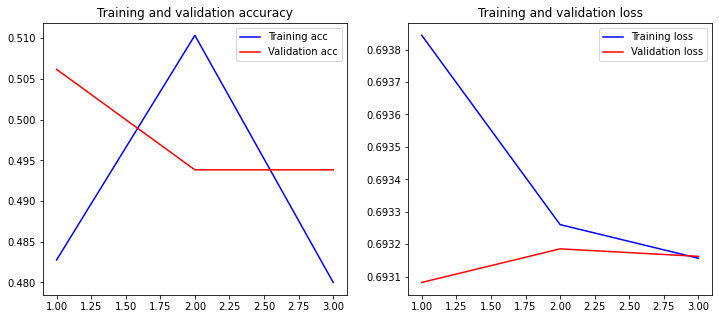

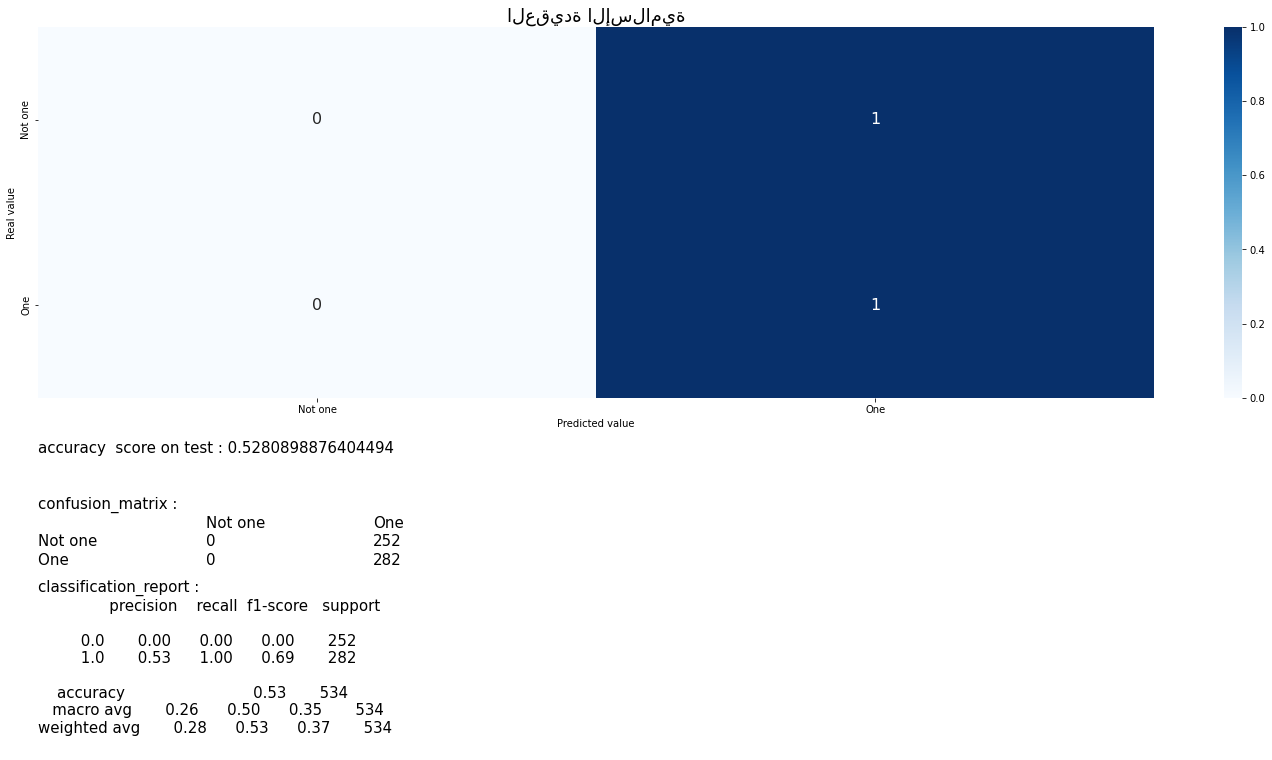

*******************************************************************************************
****************************** result for data الأطعمة والأشربة والصيد ******************************
*******************************************************************************************
tokenizeation ....
training .....
Epoch 1/10
9/9 [==============================] - 35s 4s/step - loss: 0.6940 - accuracy: 0.5018 - val_loss: 0.6927 - val_accuracy: 0.5161
Epoch 2/10
9/9 [==============================] - 33s 4s/step - loss: 0.6934 - accuracy: 0.5036 - val_loss: 0.6929 - val_accuracy: 0.5161
Epoch 3/10
9/9 [==============================] - 33s 4s/step - loss: 0.6934 - accuracy: 0.4622 - val_loss: 0.6931 - val_accuracy: 0.5161
Epoch 3: early stopping
evaluation ....
========== الأطعمة والأشربة والصيد ==========
3/3 [==============================] - 1s 248ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


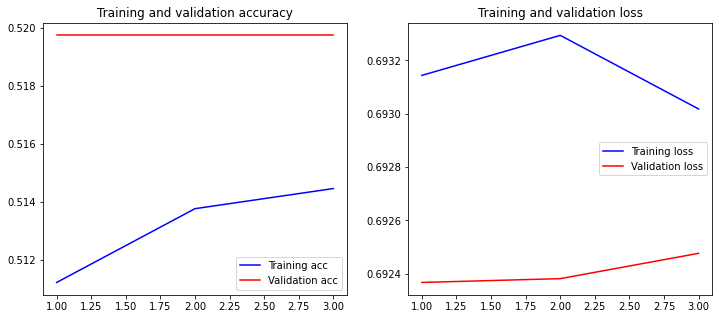

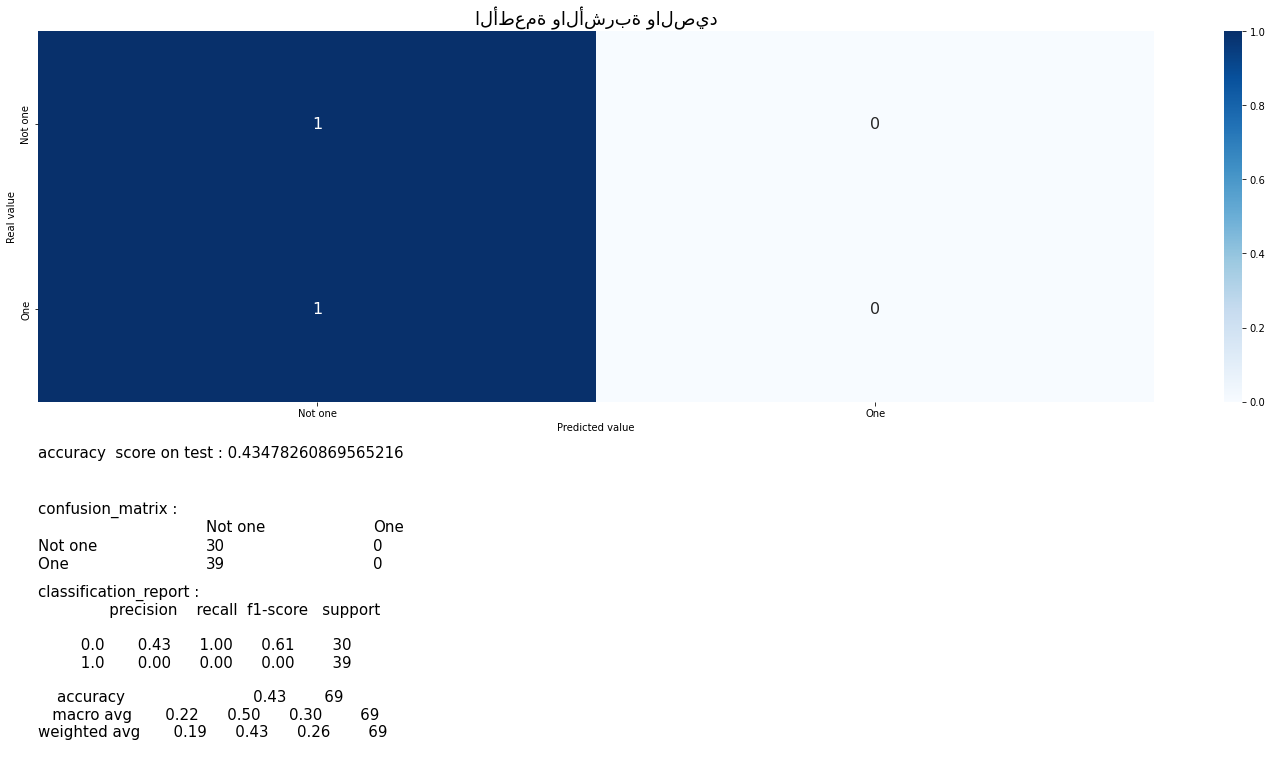

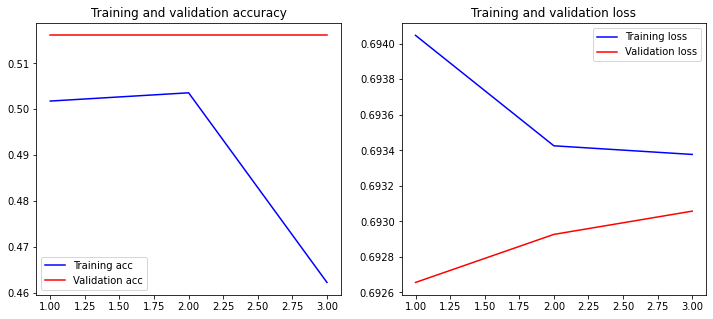

In [ ]:
tokenizers = []
def pipeline(X_train,y_train,X_test,y_test,labels):
  for i in range(len(X_train)):
      print("*******************************************************************************************")
      print("******************************","result for data",labels[i],"******************************")
      print("*******************************************************************************************")
      print("tokenizeation ....")
      X_tr,vocab_size,tokenizer = pad_sequences_vectorizer(X_train[i])
      # y_train_ = np.asarray(y_train[i]).astype('float32').reshape((-1,1))
      tokenizers.append(tokenizer)
      X_te = tokenizer.texts_to_sequences(X_test[i])
      X_te = pad_sequences(X_te, padding='post', maxlen=maxlen)
      # y_test_ = np.asarray(y_test[i]).astype('float32').reshape((-1,1))

      print("training .....")
      Network,history = train_models(X_tr,y_train[i],vocab_size,labels[i])
      Network.save(os.path.join(results_path_deep,"model_v3"+str(i)+".h5"))
      print('evaluation ....')
      evaluate_result(Network,X_te,y_test[i],labels[i],history)
pipeline(X_train,y_train,X_test,y_test,labels)

### with Count Vectorizer

# Save_Load Results

In [ ]:
def save_object(obj, filename):
    filename = os.path.join(results_path_deep,filename)
    with open(filename+".pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()
def load_object(filename):
    filename = os.path.join(results_path_deep,filename)
    with open(filename+".pkl", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

In [ ]:
# save_object(seq_Container_Result,"seq_Container_Result_deep_v3")
# save_object(save_model,"save_model_deep_v3")


# seq_Container_Result = load_object('seq_Container_Result_deep_v3')
# save_model = load_object('save_model_deep_v3')

In [ ]:
save_object(tokenizers,"tokenizers_deep_v3")

# tokenizers = load_object('tokenizers_deep_v3')

# Select best model 

In [ ]:
best_models = []
for i,label in enumerate(labels):
  best_models.append(load_model(os.path.join(results_path_deep,"model_v3"+str(i)+".h5")))

In [ ]:
save_object(best_models,'best_models_deep_v3')
# best_models = load_object('best_models_deep_v3')

In [ ]:
new_X_test = []
new_Y_test = []
for i,Y_test in enumerate(y_test):
    x_temp = []
    y_temp = []
    for j,y in enumerate(Y_test):
        if y==1:
            y_temp.append(y)
            x_temp.append(X_test[i][j])
    new_Y_test.append(y_temp) 
    new_X_test.append(x_temp)

In [ ]:
save_object(labels,"labels")
labels

In [ ]:
for i,X in enumerate(new_X_test):
  j=0
  print("*************************************************************************")
  print("*************************************************************************")
  for j,x in enumerate(X):
    best_pre = []
    print("===================================================================")
    print("Real Label :",labels[i])
    for m,model in enumerate(best_models):
      # tx = vectorizers[m].transform([x])
      tx = tokenizers[m].texts_to_sequences([x])
      tx = pad_sequences(tx, padding='post', maxlen=maxlen)
      if model.predict(tx,verbose=0)[0]>0.49:
        print("Result Model : "+str(labels[m])+" =>",max(model.predict(tx,verbose=0)[0]))
        best_pre.append(max(model.predict(tx,verbose=0)[0]))
      else:
        print("Result Model : "+str(labels[m])+" =>",min(model.predict(tx,verbose=0)[0]))
        best_pre.append(min(model.predict(tx,verbose=0)[0]))
    
    print("***** predict =>",labels[best_pre.index(max(best_pre))],max(best_pre))

*************************************************************************
*************************************************************************
Real Label : التراجم والأخبار
Result Model : التراجم والأخبار => 0.48702165
Result Model : العلم و الدعوة => 0.5078411


Streaming output truncated to the last 5000 lines.
Result Model : الحديث الشريف => 0.5159129
Result Model : الفقه وفروعه => 0.6409423
Result Model : التربية و الآداب => 0.58813095
Result Model : السياسة الشرعية => 0.49580383
Result Model : الأذكار والأدعية => 0.51009566
Result Model : مشكلات اجتماعية وفكرية => 0.49940574
Result Model : العقيدة الإسلامية => 0.5123536
Result Model : الأطعمة والأشربة والصيد => 0.49854547
***** predict => الفقه وفروعه 0.6409423
Real Label : القرآن و علومه
Result Model : التراجم والأخبار => 0.48702165
Result Model : العلم و الدعوة => 0.5078411
Result Model : التاريخ و السيرة النبوية => 0.5037218
Result Model : القرآن و علومه => 0.5168825
Result Model : الحديث الشريف => 0.5159129
Result Model : الفقه وفروعه => 0.6409423
Result Model : التربية و الآداب => 0.58813095
Result Model : السياسة الشرعية => 0.49580383
Result Model : الأذكار والأدعية => 0.51009566
Result Model : مشكلات اجتماعية وفكرية => 0.49940574
Result Model : العقيدة الإسلامية => 0.5123536
Result 